In [2]:
!pip install -q efficientnet
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0  # Thay MobileNetV2 bằng EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [3]:
# Cấu hình
original_dir = "/kaggle/input/rice-leaf-disease-image"  # Đường dẫn chứa dữ liệu gốc
output_dir = "dataset"                                    # Thư mục mới chứa tập train_val và test
test_split = 0.2                                         # Tỉ lệ test
IMAGE_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
random.seed(42)  # Đảm bảo reproducibility

# Tách dữ liệu thành train_val và test
train_val_dir = os.path.join(output_dir, 'train_val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lặp qua từng lớp
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Tạo thư mục lớp trong train_val và test
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Lấy danh sách ảnh, shuffle
    images = os.listdir(class_path)
    random.shuffle(images)

    # Tách
    num_test = int(len(images) * test_split)
    test_images = images[:num_test]
    train_val_images = images[num_test:]

    # Di chuyển ảnh vào đúng nơi
    for img in tqdm(test_images, desc=f"Copying test images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

    for img in tqdm(train_val_images, desc=f"Copying train_val images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(train_val_dir, class_name, img)
        )

print("✅ Đã tách dữ liệu thành công.")

# Kiểm tra cấu trúc dữ liệu
for root, dirs, files in os.walk(output_dir):
    print(root, ":", len(files), "files")

Copying train_val images for Brownspot: 100%|██████████| 1280/1280 [00:07<00:00, 179.08it/s]

✅ Đã tách dữ liệu thành công.
dataset : 0 files
dataset/train_val : 0 files
dataset/train_val/Bacterialblight : 1268 files
dataset/train_val/Tungro : 1047 files
dataset/train_val/Blast : 1152 files
dataset/train_val/Brownspot : 1280 files
dataset/test : 0 files
dataset/test/Bacterialblight : 316 files
dataset/test/Tungro : 261 files
dataset/test/Blast : 288 files
dataset/test/Brownspot : 320 files


In [4]:

# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Tạo generator cho tập train
train_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Tạo generator cho tập validation
val_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Tạo generator cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Số lượng lớp
NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())

print(f"Số lớp: {NUM_CLASSES}")
print(f"Số lượng ảnh train: {train_generator.samples}")
print(f"Số lượng ảnh validation: {val_generator.samples}")
print(f"Số lượng ảnh test: {test_generator.samples}")

Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Số lớp: 4
Số lượng ảnh train: 3799
Số lượng ảnh validation: 948
Số lượng ảnh test: 1185


In [8]:
# Hàm tạo model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# EfficientNetB0
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Fine-tuning: Mở khóa 20 lớp cuối
for layer in efficientnet_base.layers[:-20]:
    layer.trainable = False
for layer in efficientnet_base.layers[-20:]:
    layer.trainable = True

efficientnet_model = build_model(efficientnet_base)
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("efficientnetb0_rice_leaf_best.h5", monitor='val_loss', save_best_only=True, mode='min')

In [9]:
# Huấn luyện mô hình
efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Đánh giá mô hình trên tập validation
val_loss, val_acc = efficientnet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Đánh giá mô hình trên tập test
test_loss, test_acc = efficientnet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/30


I0000 00:00:1748775110.767059     124 service.cc:148] XLA service 0x7e1108002c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748775110.767829     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748775112.896099     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748775117.625213     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748775117.833895     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 2/60 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3125 - loss: 1.3931  

I0000 00:00:1748775125.013789     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/60 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.2843 - loss: 1.3911

E0000 00:00:1748775164.478470     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748775164.687812     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2843 - loss: 1.3908 - val_accuracy: 0.2669 - val_loss: 1.4049 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 858ms/step - accuracy: 0.3130 - loss: 1.3712 - val_accuracy: 0.2669 - val_loss: 1.4285 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 848ms/step - accuracy: 0.3249 - loss: 1.3726 - val_accuracy: 0.2669 - val_loss: 1.4228 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 847ms/step - accuracy: 0.3484 - loss: 1.3507 - val_accuracy: 0.2669 - val_loss: 1.4405 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 853ms/step - accuracy: 0.3641 - loss: 1.3215 - val_accuracy: 0.2669 - val_loss: 1.4070 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 862ms/step - accuracy: 0.3873 - loss: 1.3020 - val_accuracy: 0.4568 - val_loss: 1.3196 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 850ms/step - accuracy: 0.4194

15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 
Classification Report on Validation Set:
                 precision    recall  f1-score   support

Bacterialblight       0.59      0.62      0.61       253
          Blast       0.35      0.37      0.36       230
      Brownspot       0.60      0.80      0.69       256
         Tungro       0.45      0.21      0.29       209

       accuracy                           0.52       948
      macro avg       0.50      0.50      0.49       948
   weighted avg       0.51      0.52      0.50       948



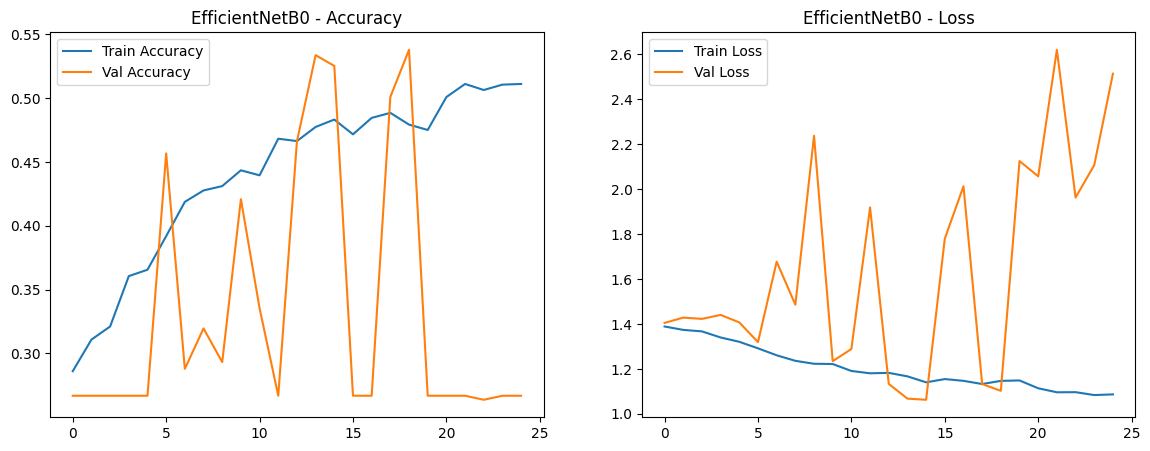

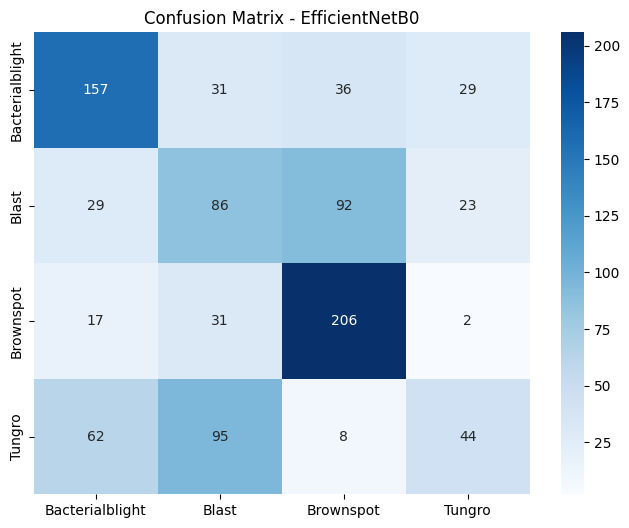

In [10]:
# Hàm vẽ biểu đồ lịch sử huấn luyện
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.savefig('training_history.png')

plot_history(efficientnet_history, "EfficientNetB0")

# Đánh giá mô hình EfficientNetB0 trên tập validation
val_generator.reset()
efficientnet_preds = efficientnet_model.predict(val_generator)
efficientnet_y_pred = np.argmax(efficientnet_preds, axis=1)
efficientnet_y_true = val_generator.classes

# Báo cáo phân loại
print("Classification Report on Validation Set:")
print(classification_report(efficientnet_y_true, efficientnet_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn
efficientnet_conf_mat = confusion_matrix(efficientnet_y_true, efficientnet_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(efficientnet_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - EfficientNetB0")
plt.savefig('confusion_matrix.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Test image path: dataset/test/Brownspot/BROWNSPOT2_108.jpg
True class: Brownspot
Predicted class: Blast
Confidence: 0.3320


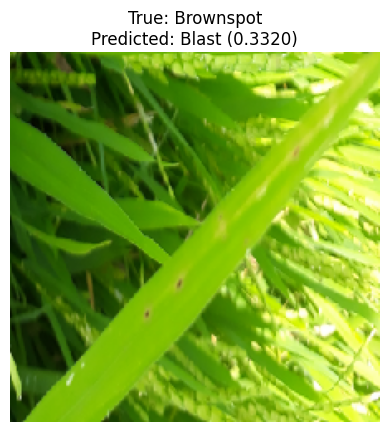

In [11]:
# Phần test ảnh ngẫu nhiên từ tập test
# Tải mô hình đã huấn luyện
model = tf.keras.models.load_model('efficientnetb0_rice_leaf_best.h5')

# Lấy danh sách tất cả ảnh trong tập test
image_paths = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

# Chọn ngẫu nhiên một ảnh
test_img_path = random.choice(image_paths)

# Tải và xử lý ảnh test
img = load_img(test_img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img) / 255.0  # Chuẩn hóa ảnh
img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch

# Dự đoán lớp
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Lấy nhãn thật từ đường dẫn
true_class = os.path.basename(os.path.dirname(test_img_path))

# Hiển thị kết quả
print(f"Test image path: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

# Hiển thị ảnh test
plt.figure()
plt.imshow(img)
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('test_result.png')

# Lưu mô hình
efficientnet_model.save("efficientnetb0_rice_final.h5")